In [309]:
import warnings
warnings.filterwarnings('ignore') # warningが出ないように設定

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder

%matplotlib inline


pd.set_option("display.max_rows", None) # pandasの表示上限をなくす
pd.set_option("display.max_columns", None) # pandasの表示上限をなくす

In [310]:
#lgbSubmission.csv: PassengerId	Pclass	Sex	SibSp	Parch	Fare で学習
#lgbSubmission2.csv: Pclass	Sex	Age	SibSp	Parch	Fare で学習
#lgbSubmission3.csv: Pclass	Sex	Age	SibSp	Parch	Fare	Embarked で学習
#lgbSubmission4.csv: SFSによる特徴選択をして学習
#lgbSubmission5.csv: 3.csvのSibSpとParchを合わせたSibSpParchを用いて学習
#lgbSubmission6.csv: 5.csvの予測結果のtest dataをtrain dataと結合させて再学習
#lgbSubmission7.csv: 右舷と左舷の部屋番号を分けたカラムを追加してAgeをカテゴライズして学習
#lgbSubmission7.csv: 7.csvでFareもカテゴライズして学習

In [311]:
data_path = './data/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
pd.set_option("display.max_columns",1000)

In [312]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [313]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [314]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


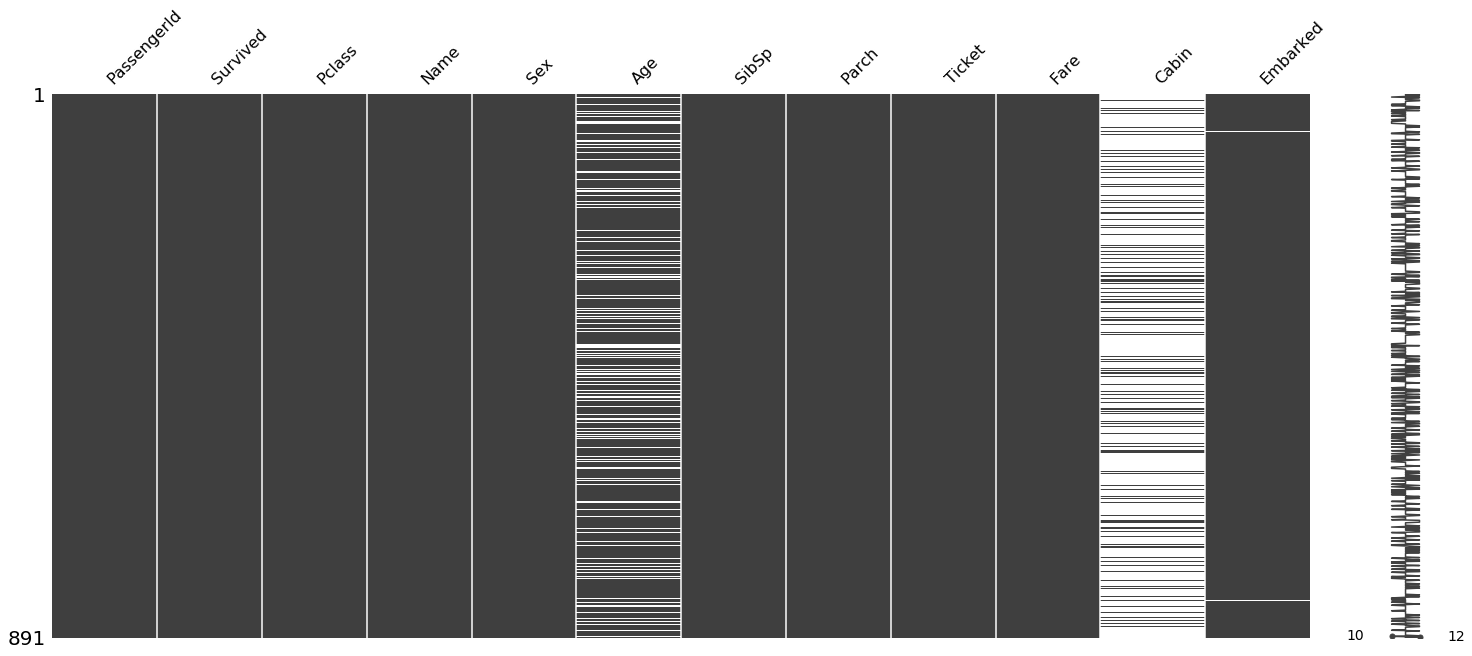

In [315]:
msno.matrix(train)

In [316]:
## 欠損値の数と割合を返す
def missing_columns(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [317]:
missing_columns(train)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [318]:
missing_columns(test)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [319]:
#Cabinは欠損値が多すぎる、PassengerId、Nameは関係ない、Ticketはよくわからないので特徴削除
#Ticketも使う
train = train.drop(columns=['PassengerId', 'Name', 'Cabin'])
test = test.drop(columns=['PassengerId', 'Name', 'Cabin'])

In [320]:
pd.value_counts(train['Embarked'])

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [321]:
#最頻値代入
train["Embarked"] = train["Embarked"].fillna("S")

In [322]:
#カテゴリ変数の変換
LE=LabelEncoder()

labels = ['Embarked','Sex']
for label in labels:
    train[label]=LE.fit_transform(train[label])
    test[label]=LE.fit_transform(test[label])

In [323]:
#Ticketの最後の数字(str)を抜き出して奇数と偶数でラベル化
train["RoomLorR"] = train["Ticket"].str[-1:]
test["RoomLorR"] = test["Ticket"].str[-1:]
train = train.drop(columns=["Ticket"])
test = test.drop(columns=["Ticket"])

In [324]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RoomLorR
0,0,3,1,22.0,1,0,7.2500,2,1
1,1,1,0,38.0,1,0,71.2833,0,9
2,1,3,0,26.0,0,0,7.9250,2,2
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,2,0


In [325]:
def roomLabels(x):
    if (x == "1") or (x == "3") or (x == "5") or (x == "7") or (x == "9"):
        return 0
    elif (x == "0") or (x == "2") or (x == "4") or (x == "6") or (x == "8"):
        return 1

train["RoomLorR"] = train["RoomLorR"].apply(roomLabels)
test["RoomLorR"] = test["RoomLorR"].apply(roomLabels)

In [326]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RoomLorR
0,0,3,1,22.0,1,0,7.2500,2,0.0
1,1,1,0,38.0,1,0,71.2833,0,0.0
2,1,3,0,26.0,0,0,7.9250,2,1.0
3,1,1,0,35.0,1,0,53.1000,2,0.0
4,0,3,1,35.0,0,0,8.0500,2,1.0


In [327]:
missing_columns(train)

,Total,Percent
Age,177,19.865320
RoomLorR,4,0.448934
Embarked,0,0.000000
Fare,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000
Survived,0,0.000000


In [328]:
missing_columns(test)

,Total,Percent
Age,86,20.574163
Fare,1,0.239234
RoomLorR,0,0.000000
Embarked,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000


In [329]:
pd.value_counts(train['RoomLorR'])

0.0    468
1.0    419
Name: RoomLorR, dtype: int64

In [330]:
#最頻値代入
train["RoomLorR"] = train["RoomLorR"].fillna(0.0)

In [331]:
#Ageをカテゴライズ
def age(x):
    if (0 <= x) and (x < 10):
        return 0
    elif (10 <= x) and (x < 20):
        return 1
    elif (20 <= x) and (x < 30):
        return 2
    elif (30 <= x) and (x < 40):
        return 3
    elif (40 <= x) and (x < 50):
        return 4
    elif (50 <= x) and (x < 60):
        return 5
    elif (60 <= x) and (x < 70):
        return 6
    elif (70 <= x) and (x <= 80):
        return 7

In [332]:
train["aboutAge"] = train["Age"].apply(age)
test["aboutAge"] = test["Age"].apply(age)
train = train.drop(columns=["Age"])
test = test.drop(columns=["Age"])

In [333]:
#Fareをカテゴライズ
def fare(x):
    if (0.0 <= x) and (x < 50.0):
        return 0
    elif (50.0 <= x) and (x < 100.0):
        return 1
    elif (100.0 <= x) and (x < 150.0):
        return 2
    elif (150.0 <= x) and (x < 200.0):
        return 3
    elif (200.0 <= x) and (x < 250.0):
        return 4
    elif (250.0 <= x) and (x < 300.0):
        return 5
    elif (300.0 <= x) and (x < 350.0):
        return 6
    elif (350.0 <= x) and (x < 400.0):
        return 7
    elif (400.0 <= x) and (x < 450.0):
        return 8
    elif (450.0 <= x) and (x < 500.0):
        return 9
    elif (500.0 <= x):
        return 10

In [334]:
#train["aboutFare"] = train["Fare"].apply(age)
#test["aboutFare"] = test["Fare"].apply(age)
#train = train.drop(columns=["Fare"])
#test = test.drop(columns=["Fare"])

In [335]:
train.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,RoomLorR,aboutAge
0,0,3,1,1,0,7.2500,2,0.0,2.0
1,1,1,0,1,0,71.2833,0,0.0,3.0
2,1,3,0,0,0,7.9250,2,1.0,2.0
3,1,1,0,1,0,53.1000,2,0.0,3.0
4,0,3,1,0,0,8.0500,2,1.0,3.0


In [336]:
train = train.fillna(train.mean()) # 平均値代入
test = test.fillna(test.mean()) # 平均値代入

In [337]:
missing_columns(train)

,Total,Percent
aboutAge,0,0.0
RoomLorR,0,0.0
Embarked,0,0.0
Fare,0,0.0
Parch,0,0.0
SibSp,0,0.0
Sex,0,0.0
Pclass,0,0.0
Survived,0,0.0


([array([ 80.,  97., 372.]), array([216., 184., 491.])],
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <a list of 2 Lists of Patches objects>)

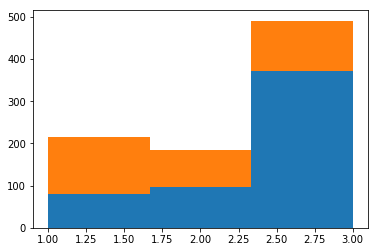

In [338]:
split_data = []
for survived in [0,1]:
    split_data.append(train[train.Survived==survived])

temp = [i["Pclass"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=3)

([array([ 24.,   0.,  61.,   0., 143., 125.,  94.,   0.,   0.,  55.,   0.,
          28.,   0.,  13.,   0.,   6.]),
  array([ 62.,   0., 102.,   0., 220., 177., 167.,   0.,   0.,  89.,   0.,
          48.,   0.,  19.,   0.,   7.])],
 array([0.    , 0.4375, 0.875 , 1.3125, 1.75  , 2.1875, 2.625 , 3.0625,
        3.5   , 3.9375, 4.375 , 4.8125, 5.25  , 5.6875, 6.125 , 6.5625,
        7.    ]),
 <a list of 2 Lists of Patches objects>)

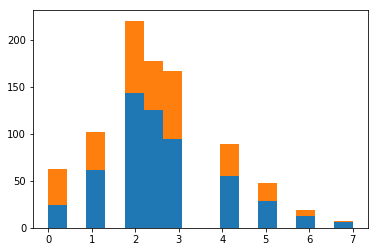

In [339]:
#欠損値は平均値で補った関係で20代後半が突出
temp = [i["aboutAge"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=16)

([array([ 81.,   0.,   0., 468.]), array([314.,   0.,   0., 577.])],
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 <a list of 2 Lists of Patches objects>)

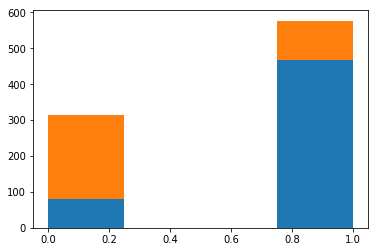

In [340]:
#femaleの方が生存率が高い
temp = [i["Sex"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=4)

([array([398.,   0.,  97.,   0.,  15.,   0.,  12.,   0.,  15.,   0.,   5.,
           0.,   0.,   0.,   0.,   7.]),
  array([608.,   0., 209.,   0.,  28.,   0.,  16.,   0.,  18.,   0.,   5.,
           0.,   0.,   0.,   0.,   7.])],
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. ]),
 <a list of 2 Lists of Patches objects>)

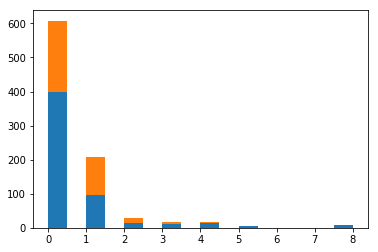

In [341]:
temp = [i["SibSp"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=16)

([array([445.,   0.,  53.,   0.,  40.,   0.,   2.,   0.,   4.,   0.,   4.,
           1.]),
  array([678.,   0., 118.,   0.,  80.,   0.,   5.,   0.,   4.,   0.,   5.,
           1.])],
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 2 Lists of Patches objects>)

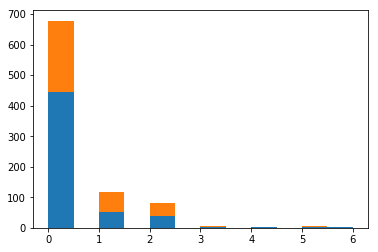

In [342]:
temp = [i["Parch"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=12)

([array([ 75.,   0.,   0.,  47.,   0., 427.]),
  array([168.,   0.,   0.,  77.,   0., 646.])],
 array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        ]),
 <a list of 2 Lists of Patches objects>)

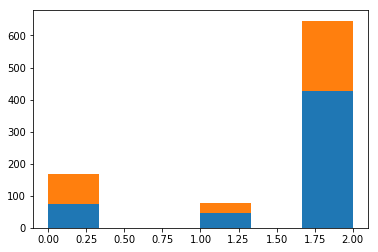

In [343]:
temp = [i["Embarked"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=6)

([array([293.,   0.,   0., 256.]), array([472.,   0.,   0., 419.])],
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 <a list of 2 Lists of Patches objects>)

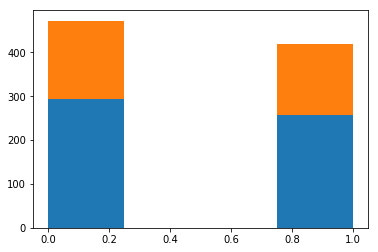

In [344]:
temp = [i["RoomLorR"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=4)

([array([499.,  36.,   8.,   0.,   4.,   2.,   0.,   0.,   0.,   0.]),
  array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.])],
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 2 Lists of Patches objects>)

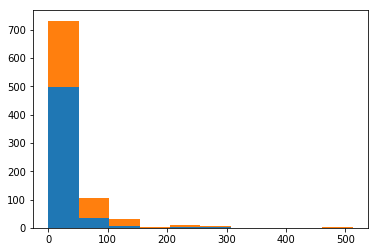

In [345]:
temp = [i["Fare"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=10)

In [346]:
train["SibSpParch"] = train["SibSp"] + train["Parch"]
test["SibSpParch"] = test["SibSp"] + test["Parch"]
train = train.drop(columns=["SibSp", "Parch"])
test = test.drop(columns=["SibSp", "Parch"])

In [347]:
train.head()

,Survived,Pclass,Sex,Fare,Embarked,RoomLorR,aboutAge,SibSpParch
0,0,3,1,7.2500,2,0.0,2.0,1
1,1,1,0,71.2833,0,0.0,3.0,1
2,1,3,0,7.9250,2,1.0,2.0,0
3,1,1,0,53.1000,2,0.0,3.0,1
4,0,3,1,8.0500,2,1.0,3.0,0


([array([374.,  72.,  43.,   8.,  12.,  19.,   8.,   6.,   0.,   7.]),
  array([537., 161., 102.,  29.,  15.,  22.,  12.,   6.,   0.,   7.])],
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 2 Lists of Patches objects>)

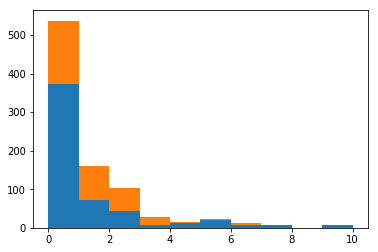

In [348]:
split_data = []
for survived in [0,1]:
    split_data.append(train[train.Survived==survived])
    
temp = [i["SibSpParch"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=10)

In [349]:
#train data と test data をそれぞれ特徴量とラベルに分ける
from sklearn.model_selection import train_test_split
trainFeatures = train.drop(columns='Survived')
trainLabels = train.Survived

In [350]:
#light gbm 用データ分割
X_train, X_test, y_train, y_test = train_test_split(trainFeatures, trainLabels, test_size=0.2, random_state=72)

#モデル用dataset生成
import lightgbm as lgb
lgbTrain = lgb.Dataset(X_train, y_train)
lgbTest = lgb.Dataset(X_test, y_test)
lgbFinalTrain = lgb.Dataset(trainFeatures, trainLabels)

In [351]:
#light gbm

lgbParams = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.01,      # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.6,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

#学習
evaluationResults = {}
lgbModel = lgb.train(train_set=lgbTrain,
                     params=lgbParams,
                     valid_sets=[lgbTrain, lgbTest], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluationResults,
                     num_boost_round=5000,
                     early_stopping_rounds=1000,
                     verbose_eval=20
                    )

optimum_boost_rounds = lgbModel.best_iteration

Training until validation scores don't improve for 1000 rounds.
[20]	Train's binary_logloss: 0.616357	Test's binary_logloss: 0.625672
[40]	Train's binary_logloss: 0.588174	Test's binary_logloss: 0.595337
[60]	Train's binary_logloss: 0.581703	Test's binary_logloss: 0.588341
[80]	Train's binary_logloss: 0.5715	Test's binary_logloss: 0.57732
[100]	Train's binary_logloss: 0.565653	Test's binary_logloss: 0.571116
[120]	Train's binary_logloss: 0.56222	Test's binary_logloss: 0.567669
[140]	Train's binary_logloss: 0.552686	Test's binary_logloss: 0.55782
[160]	Train's binary_logloss: 0.553899	Test's binary_logloss: 0.558816
[180]	Train's binary_logloss: 0.538481	Test's binary_logloss: 0.544054
[200]	Train's binary_logloss: 0.524861	Test's binary_logloss: 0.53149
[220]	Train's binary_logloss: 0.516517	Test's binary_logloss: 0.524029
[240]	Train's binary_logloss: 0.502851	Test's binary_logloss: 0.51051
[260]	Train's binary_logloss: 0.496377	Test's binary_logloss: 0.504682
[280]	Train's binary_log

[2380]	Train's binary_logloss: 0.278732	Test's binary_logloss: 0.38789
[2400]	Train's binary_logloss: 0.278593	Test's binary_logloss: 0.388088
[2420]	Train's binary_logloss: 0.278266	Test's binary_logloss: 0.388459
[2440]	Train's binary_logloss: 0.277669	Test's binary_logloss: 0.388779
[2460]	Train's binary_logloss: 0.276562	Test's binary_logloss: 0.389228
[2480]	Train's binary_logloss: 0.27569	Test's binary_logloss: 0.3895
[2500]	Train's binary_logloss: 0.2754	Test's binary_logloss: 0.389708
[2520]	Train's binary_logloss: 0.27445	Test's binary_logloss: 0.389563
[2540]	Train's binary_logloss: 0.273768	Test's binary_logloss: 0.389844
[2560]	Train's binary_logloss: 0.273335	Test's binary_logloss: 0.38994
[2580]	Train's binary_logloss: 0.272026	Test's binary_logloss: 0.390021
[2600]	Train's binary_logloss: 0.271261	Test's binary_logloss: 0.390703
[2620]	Train's binary_logloss: 0.270216	Test's binary_logloss: 0.391088
[2640]	Train's binary_logloss: 0.269513	Test's binary_logloss: 0.391279


In [352]:
#from sklearn.ensemble import GradientBoostingClassifier #GBM algorithm
#from sklearn.grid_search import GridSearchCV #Perforing grid search

#param_test3 = {'min_samples_leaf':list(range(30,71,10))}
#gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, min_samples_split=800, max_depth=7,max_features='sqrt', subsample=0.8, random_state=10), 
#param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch3.fit(trainFeatures,trainLabels)
#mean_list = []
#for s in gsearch3.grid_scores_:
#    mean_list.append(s[1])
#plt.figure(figsize=(4,2))
#plt.plot(list(range(30,71,10)), mean_list)
#plt.title("GridSearchCV Score")
#plt.xlabel("min_samples_leaf")
#plt.show()
#gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

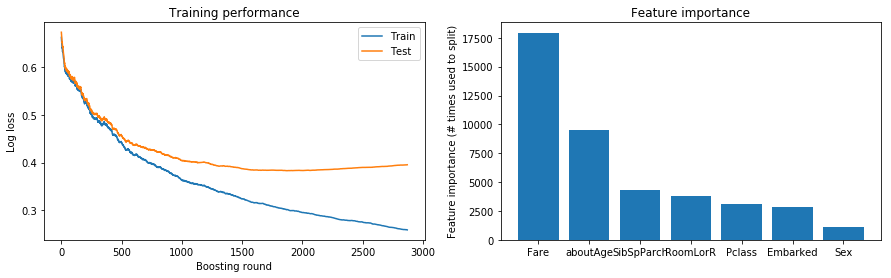

In [353]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluationResults['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluationResults['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgbModel.feature_name(), 
                            'importance': lgbModel.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [354]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
preds = np.round(lgbModel.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.8547486033519553
Precision score = 	 0.8194444444444444
Recall score =   	 0.8194444444444444
F1 score =      	 0.8194444444444444


In [355]:
#予測用datasetで予測
lgbFinal = lgb.train(train_set=lgbFinalTrain,
                      params=lgbParams,
                      num_boost_round=optimum_boost_rounds,
                      verbose_eval=0
                      )

lgbPred = np.round(lgbFinal.predict(test)).astype(int)

In [356]:
# テスト値を再読み込みして，randomForestでクラス分類したカラムを追加
df_out = pd.read_csv("./data/test.csv")
testLabels = pd.Series(lgbPred)
df_out["Survived"] = testLabels

# outputディレクトリに出力する
#df_out[["PassengerId","Survived"]].to_csv("./data/lgbSubmission5.csv",index=False)

In [357]:
#予測結果でラベル付けしたtest dataを追加して再度学習する

In [358]:
df_out.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [359]:
testFeatures = test

In [360]:
testFeatures.head()

,Pclass,Sex,Fare,Embarked,RoomLorR,aboutAge,SibSpParch
0,3,1,7.8292,1,0,3.0,0
1,3,0,7.0000,2,1,4.0,1
2,2,1,9.6875,1,1,6.0,0
3,3,1,8.6625,2,1,2.0,0
4,3,0,12.2875,2,1,2.0,2


In [361]:
trainFeatures.head()

,Pclass,Sex,Fare,Embarked,RoomLorR,aboutAge,SibSpParch
0,3,1,7.2500,2,0.0,2.0,1
1,1,0,71.2833,0,0.0,3.0,1
2,3,0,7.9250,2,1.0,2.0,0
3,1,0,53.1000,2,0.0,3.0,1
4,3,1,8.0500,2,1.0,3.0,0


In [362]:
mixDataFeatures = pd.concat([trainFeatures,testFeatures])
mixDataLabels = pd.concat([trainLabels, testLabels])

In [363]:
mixDataFeatures.shape

(1309, 7)

In [364]:
mixDataFeatures.head()

,Pclass,Sex,Fare,Embarked,RoomLorR,aboutAge,SibSpParch
0,3,1,7.2500,2,0.0,2.0,1
1,1,0,71.2833,0,0.0,3.0,1
2,3,0,7.9250,2,1.0,2.0,0
3,1,0,53.1000,2,0.0,3.0,1
4,3,1,8.0500,2,1.0,3.0,0


In [365]:
mixDataLabels.head()

0    0
1    1
2    1
3    1
4    0
dtype: int64

In [366]:
#light gbm 用データ分割
X_train, X_test, y_train, y_test = train_test_split(mixDataFeatures, mixDataLabels, test_size=0.2, random_state=72)

#モデル用dataset生成
import lightgbm as lgb
lgbTrain = lgb.Dataset(X_train, y_train)
lgbTest = lgb.Dataset(X_test, y_test)
lgbFinalTrain = lgb.Dataset(trainFeatures, trainLabels)

In [367]:
#light gbm

lgbParams = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.02,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.6,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

#学習
evaluationResults = {}
lgbModel = lgb.train(train_set=lgbTrain,
                     params=lgbParams,
                     valid_sets=[lgbTrain, lgbTest], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluationResults,
                     num_boost_round=5000,
                     early_stopping_rounds=1000,
                     verbose_eval=20
                    )

optimum_boost_rounds = lgbModel.best_iteration

Training until validation scores don't improve for 1000 rounds.
[20]	Train's binary_logloss: 0.558156	Test's binary_logloss: 0.556457
[40]	Train's binary_logloss: 0.505537	Test's binary_logloss: 0.511397
[60]	Train's binary_logloss: 0.49275	Test's binary_logloss: 0.502967
[80]	Train's binary_logloss: 0.474829	Test's binary_logloss: 0.487266
[100]	Train's binary_logloss: 0.464736	Test's binary_logloss: 0.477244
[120]	Train's binary_logloss: 0.457678	Test's binary_logloss: 0.472228
[140]	Train's binary_logloss: 0.441632	Test's binary_logloss: 0.457451
[160]	Train's binary_logloss: 0.443296	Test's binary_logloss: 0.459112
[180]	Train's binary_logloss: 0.419472	Test's binary_logloss: 0.440257
[200]	Train's binary_logloss: 0.399399	Test's binary_logloss: 0.423538
[220]	Train's binary_logloss: 0.38748	Test's binary_logloss: 0.413471
[240]	Train's binary_logloss: 0.36941	Test's binary_logloss: 0.397625
[260]	Train's binary_logloss: 0.361252	Test's binary_logloss: 0.390649
[280]	Train's binary

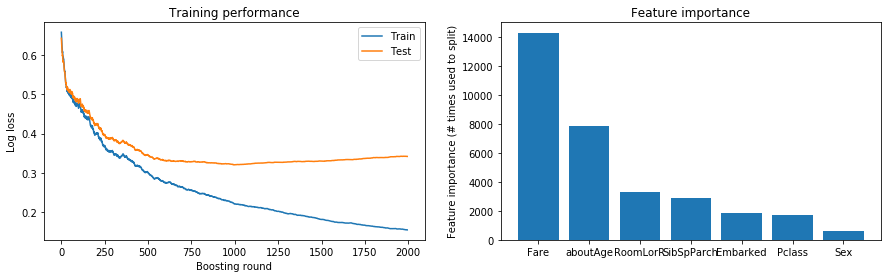

In [368]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluationResults['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluationResults['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgbModel.feature_name(), 
                            'importance': lgbModel.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [369]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
preds = np.round(lgbModel.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.9007633587786259
Precision score = 	 0.891566265060241
Recall score =   	 0.8131868131868132
F1 score =      	 0.8505747126436781


In [370]:
#予測用datasetで予測
lgbFinal = lgb.train(train_set=lgbFinalTrain,
                      params=lgbParams,
                      num_boost_round=optimum_boost_rounds,
                      verbose_eval=0
                      )

lgbPred = np.round(lgbFinal.predict(test)).astype(int)

In [371]:
# テスト値を再読み込みして，randomForestでクラス分類したカラムを追加
df_out = pd.read_csv("./data/test.csv")
testLabels = pd.Series(lgbPred)
df_out["Survived"] = testLabels

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("./data/lgbSubmission8.csv",index=False)

In [ ]:
#特徴量選択してもう一回

In [ ]:
trainCp = train
testCp = test

In [ ]:
#train data と test data をそれぞれ特徴量とラベルに分ける
trainFeatures = trainCp.drop(columns='Survived')
trainLabels = trainCp.Survived

In [ ]:
#SFSでの特徴選択
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=4)

sfs = SFS(knn, #学習器
          k_features=7, #特徴の最大選択数
          forward=True, #Trueでforward selection, Falseでback
          floating=False, #forward selectionの亜種を行うためのもの
          scoring='accuracy', #評価指標
          cv=5) #クロスバリデーション(cv=0とすると、最終的に選ばれる特徴が変わる)

sfs = sfs.fit(trainFeatures, trainLabels)

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.7, 0.9])
plt.grid()
plt.show()

In [ ]:
sfs = sfs.fit(trainFeatures, trainLabels)
sfs.subsets_

In [ ]:
#knnを使ったSFSの結果より4つの特徴を選択
trainFeatures = trainFeatures.drop(columns=['SibSp', 'Age', 'Fare'])
testCp = testCp.drop(columns=['SibSp', 'Age', 'Fare'])

In [ ]:
#相関関係より4つの特徴を選択
#trainFeatures = trainFeatures.drop(columns=['SibSp', 'Age', 'Parch'])
#testCp = testCp.drop(columns=['SibSp', 'Age', 'Parch'])

In [ ]:
trainFeatures.head()

In [ ]:
#light gbm 用データ分割
X_train, X_test, y_train, y_test = train_test_split(trainFeatures, trainLabels, test_size=0.2, random_state=72)

#モデル用dataset生成
import lightgbm as lgb
lgbTrain = lgb.Dataset(X_train, y_train)
lgbTest = lgb.Dataset(X_test, y_test)
lgbFinalTrain = lgb.Dataset(trainFeatures, trainLabels)

In [ ]:
#light gbm

lgbParams = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.02,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

#学習
evaluationResults = {}
lgbModel = lgb.train(train_set=lgbTrain,
                     params=lgbParams,
                     valid_sets=[lgbTrain, lgbTest], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluationResults,
                     num_boost_round=500,
                     early_stopping_rounds=100,
                     verbose_eval=20
                    )

optimum_boost_rounds = lgbModel.best_iteration

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluationResults['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluationResults['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgbModel.feature_name(), 
                            'importance': lgbModel.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [ ]:
preds = np.round(lgbModel.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

In [ ]:
#予測用datasetで予測
lgbFinal = lgb.train(train_set=lgbFinalTrain,
                      params=lgbParams,
                      num_boost_round=optimum_boost_rounds,
                      verbose_eval=0
                      )

lgbPred = np.round(lgbFinal.predict(test)).astype(int)

In [ ]:
# テスト値を再読み込みして，randomForestでクラス分類したカラムを追加
df_out = pd.read_csv("./data/test.csv")
lgbPred = pd.Series(lgbPred)
df_out["Survived"] = lgbPred

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("./data/lgbSubmission4.csv",index=False)

In [ ]:
#PCA
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
sns.pairplot(trainFeatures)

In [ ]:
#次元圧縮
pca = PCA(n_components=5)
trainFeatures = pca.fit_transform(trainFeatures.values)
trainFeatures = pd.DataFrame(trainFeatures)

In [ ]:
trainFeatures.head()

In [ ]:
plt.Figure()
plt.scatter(trainFeatures[:,0], trainFeatures[:,1], trainFeatures[:,2])
plt.show()

In [ ]:
#light gbm 用データ分割
X_train, X_test, y_train, y_test = train_test_split(trainFeatures, trainLabels, test_size=0.2, random_state=72)

#モデル用dataset生成
import lightgbm as lgb
lgbTrain = lgb.Dataset(X_train, y_train)
lgbTest = lgb.Dataset(X_test, y_test)
lgbFinalTrain = lgb.Dataset(trainFeatures, trainLabels)

In [ ]:
#light gbm

lgbParams = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.02,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

#学習
evaluationResults = {}
lgbModel = lgb.train(train_set=lgbTrain,
                     params=lgbParams,
                     valid_sets=[lgbTrain, lgbTest], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluationResults,
                     num_boost_round=500,
                     early_stopping_rounds=100,
                     verbose_eval=20
                    )

optimum_boost_rounds = lgbModel.best_iteration

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluationResults['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluationResults['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgbModel.feature_name(), 
                            'importance': lgbModel.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [ ]:
preds = np.round(lgbModel.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))